In [1]:
# Clasificador de tejido sano y tejido cancerígeno en imágenes microscópicas del esófago


# Librerias

In [50]:
import warnings
warnings.filterwarnings(action='ignore')
import random
import pickle
import numpy as np
import pandas as pd
from skimage.io import imshow, imread
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Perceptron
import matplotlib.pyplot as plt
import seaborn as sns
import os
import zipfile
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score,f1_score, roc_auc_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import scipy.stats as stats

In [3]:
# Rutas
pathDatos = os.path.join(os.path.pardir,'datos')

In [4]:
# identificador de las imágenes y etiquetas
dfids = pd.read_csv(os.path.join(pathDatos,'ClasesImagenes.csv'))

In [5]:
dfids.head()

,image_filename,class_number
0,im_4_0.png,0
1,im_21_0.png,0
2,im_9_0.png,0
3,im_8_0.png,0
4,im_15_0.png,0


In [6]:
type(dfids)

pandas.core.frame.DataFrame

In [7]:
# tamaño del FataFrame
dfids.shape

(5063, 2)

In [8]:
# Imágenes por cada una de las clases
dfids.class_number.value_counts()

class_number
1    3594
0    1469
Name: count, dtype: int64

In [9]:
# la columna class_number, es nuestra variable objetivo, la almacenaremos en un objeto de numpy
y = dfids.class_number

In [10]:
type(y)

pandas.core.series.Series

## Extracción y lectura de las imágenes

In [11]:
pathImagen = os.path.join(pathDatos,'CarpetaImagenes.zip')

with zipfile.ZipFile(pathImagen, 'r') as zip_ref:
    zip_ref.extractall(pathDatos)
print("Archivos descomprimidos exitosamente.")   

Archivos descomprimidos exitosamente.


# Exploración

In [12]:
imagenn = 'im_4_0.png'
pathimagenn = os.path.join(pathDatos,imagenn)
imag = imread(pathimagenn, as_gray=True)

In [13]:
type(imag)

numpy.ndarray

In [14]:
# Dimensiones de las imagenes
imag.shape

(260, 260)

In [15]:
imag[0]

array([0.08322275, 0.08322275, 0.08322275, 0.08322275, 0.08322275,
       0.08322275, 0.08322275, 0.08322275, 0.08322275, 0.08322275,
       0.08322275, 0.08322275, 0.08322275, 0.08322275, 0.08322275,
       0.08322275, 0.08322275, 0.08322275, 0.08322275, 0.08322275,
       0.08322275, 0.08322275, 0.08322275, 0.08322275, 0.08322275,
       0.08322275, 0.08322275, 0.08322275, 0.08322275, 0.08322275,
       0.08322275, 0.08322275, 0.08322275, 0.08322275, 0.08322275,
       0.08322275, 0.08322275, 0.08322275, 0.08322275, 0.08322275,
       0.08322275, 0.08322275, 0.08322275, 0.08322275, 0.08322275,
       0.08322275, 0.08322275, 0.08322275, 0.08322275, 0.08322275,
       0.08322275, 0.08322275, 0.08322275, 0.08322275, 0.08322275,
       0.08322275, 0.08322275, 0.08322275, 0.08322275, 0.08322275,
       0.08322275, 0.08322275, 0.08322275, 0.08322275, 0.08322275,
       0.08322275, 0.08322275, 0.08322275, 0.08322275, 0.08322275,
       0.08322275, 0.08322275, 0.08322275, 0.08322275, 0.08322

In [16]:
# Exploramos el nivel de coloración de algunos de los pixeles de la imagen
imag[72:80, 170:190]

array([[0.29998118, 0.29998118, 0.30278667, 0.30504157, 0.30784706,
        0.30784706, 0.30784706, 0.31262471, 0.3154302 , 0.32246275,
        0.32246275, 0.32526824, 0.32526824, 0.33032863, 0.33988392,
        0.34185608, 0.34466157, 0.34972196, 0.35169412, 0.34691647],
       [0.27947176, 0.28227725, 0.28424941, 0.29014314, 0.29211529,
        0.29211529, 0.29520353, 0.29717569, 0.29998118, 0.30278667,
        0.30278667, 0.30504157, 0.30504157, 0.31262471, 0.32049059,
        0.32526824, 0.33032863, 0.33230078, 0.33032863, 0.33032863],
       [0.26654549, 0.26654549, 0.27215647, 0.27721686, 0.27947176,
        0.28424941, 0.28424941, 0.29014314, 0.29014314, 0.29014314,
        0.29014314, 0.29211529, 0.29520353, 0.29717569, 0.29998118,
        0.30784706, 0.3154302 , 0.3176851 , 0.32049059, 0.3154302 ],
       [0.2614851 , 0.2614851 , 0.26345725, 0.26345725, 0.27215647,
        0.27721686, 0.27721686, 0.27947176, 0.27947176, 0.27721686,
        0.27721686, 0.27947176, 0.28227725, 0

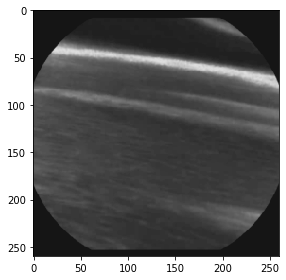

In [17]:
imshow(imag)

**Ahora vamos a hacer lo mismo para todas las imagenes**

In [18]:
dfids['image_filename']

0          im_4_0.png
1         im_21_0.png
2          im_9_0.png
3          im_8_0.png
4         im_15_0.png
            ...      
5058    im_114_55.png
5059      im_7_55.png
5060     im_52_55.png
5061     im_10_55.png
5062    im_111_55.png
Name: image_filename, Length: 5063, dtype: object

In [19]:
img = dfids['image_filename'].apply(lambda x: imread(os.path.join(pathDatos, x), as_gray=True))

In [20]:
type(img)

pandas.core.series.Series

In [21]:
help(imread)

Help on function imread in module skimage.io._io:

imread(fname, as_gray=False, plugin=None, **plugin_args)
    Load an image from file.
    
    Parameters
    ----------
    fname : string
        Image file name, e.g. ``test.jpg`` or URL.
    as_gray : bool, optional
        If True, convert color images to gray-scale (64-bit floats).
        Images that are already in gray-scale format are not converted.
    plugin : str, optional
        Name of plugin to use.  By default, the different plugins are
        tried (starting with imageio) until a suitable
        candidate is found.  If not given and fname is a tiff file, the
        tifffile plugin will be used.
    
    Other Parameters
    ----------------
    plugin_args : keywords
        Passed to the given plugin.
    
    Returns
    -------
    img_array : ndarray
        The different color bands/channels are stored in the
        third dimension, such that a gray-image is MxN, an
        RGB-image MxNx3 and an RGBA-image M

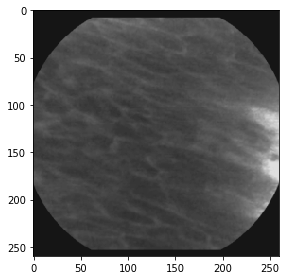

In [22]:
imshow(img[10])

- Dimensión 0: 260 renglones de pixeles de arriba a abajo
- Dimensión 1: 260 columnas de pixeles de izquierda a derecha

**Transformar imágenes en vectores**

In [23]:
# Cantidad de elementos en la serie
img.shape

(5063,)

In [24]:
img

0       [[0.08322274509803922, 0.08322274509803922, 0....
1       [[0.08322274509803922, 0.08322274509803922, 0....
2       [[0.08322274509803922, 0.08322274509803922, 0....
3       [[0.08322274509803922, 0.08322274509803922, 0....
4       [[0.08322274509803922, 0.08322274509803922, 0....
                              ...                        
5058    [[0.08322274509803922, 0.08322274509803922, 0....
5059    [[0.08322274509803922, 0.08322274509803922, 0....
5060    [[0.08322274509803922, 0.08322274509803922, 0....
5061    [[0.08322274509803922, 0.08322274509803922, 0....
5062    [[0.08322274509803922, 0.08322274509803922, 0....
Name: image_filename, Length: 5063, dtype: object

In [25]:
# Cada elemento de mi secuencia es una matriz de 260 x 260
img[3673].shape

(260, 260)

*Lo primero es transformar la secuencia de matrices img en una sola matriz*

In [26]:
IMG = np.stack(img, axis=0)   # Toma una secuencia de matrices y las apila a lo largo
                              # de un tercer eje para hacer una solo arreglo
IMG.shape

(5063, 260, 260)

In [27]:
type(IMG)

numpy.ndarray

In [28]:
IMG

array([[[0.08322275, 0.08322275, 0.08322275, ..., 0.08322275,
         0.08322275, 0.08322275],
        [0.08322275, 0.08322275, 0.08322275, ..., 0.08322275,
         0.08322275, 0.08322275],
        [0.08322275, 0.08322275, 0.08322275, ..., 0.08322275,
         0.08322275, 0.08322275],
        ...,
        [0.08322275, 0.08322275, 0.08322275, ..., 0.08322275,
         0.08322275, 0.08322275],
        [0.08322275, 0.08322275, 0.08322275, ..., 0.08322275,
         0.08322275, 0.08322275],
        [0.08322275, 0.08322275, 0.08322275, ..., 0.08322275,
         0.08322275, 0.08322275]],

       [[0.08322275, 0.08322275, 0.08322275, ..., 0.08322275,
         0.08322275, 0.08322275],
        [0.08322275, 0.08322275, 0.08322275, ..., 0.08322275,
         0.08322275, 0.08322275],
        [0.08322275, 0.08322275, 0.08322275, ..., 0.08322275,
         0.08322275, 0.08322275],
        ...,
        [0.08322275, 0.08322275, 0.08322275, ..., 0.08322275,
         0.08322275, 0.08322275],
        [0.0

Ahora aplanamos la matriz de 2D (260x260 pixeles) de cada imagen, para obtener un vector por imagen.

In [29]:
X = IMG.reshape(5063, 67600)
X.shape

(5063, 67600)

**Visualizamos ejemplos de ambas clases de imagenes**

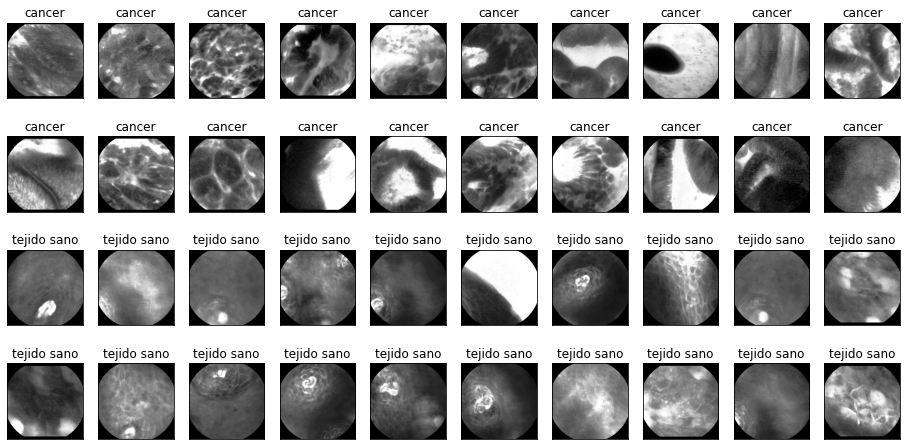

In [30]:
# Agrupamos por nuestra variable objetivo
porClase = dfids.groupby('class_number')

# Elijimos al azar n muestras de cada subconjunto y guardamos la posición de las
# imagenes cancerigenas en la lista "c" y en  "s" las de tejido sano.
n = 20
c = random.sample(porClase.get_group(1).index.tolist(), n)
s = random.sample(porClase.get_group(0).index.tolist(), n)


# Creamos el espacio para las 40 imagenes que vamos a desplegar
fig = plt.figure(figsize=(16, 8))
columns = 10
rows = 4

# Desplegamos las imagenes
for i in range(0, 40):
    fig.add_subplot( rows, columns, i+1)
    if i < 20:
        plt.imshow(img[c[i]], cmap='Greys_r')
        plt.title('cancer')
        plt.xticks([])
        plt.yticks([])
    else:
        plt.imshow(img[s[i-20]], cmap='Greys_r')
        plt.title('tejido sano')
        plt.xticks([])
        plt.yticks([])
plt.show()

# Entrenamiento

## Crear subconjuntos de entrenamiento y prueba

In [31]:
X_train, X_test, y_train, y_test = train_test_split( X, y,
                                                    test_size=0.3,
                                                    shuffle=True,
                                                    random_state=0)

In [32]:
# ¿Cómo son los conjuntos de entrenamiento y prueba?
print("Training set")
print("X: ", X_train.shape)
print("y: ", y_train.shape)
unique, counts = np.unique(y_train, return_counts=True)
print('Tejido Sano:        ', counts[0],'\nDisplasia o Cáncer: ', counts[1],'\n')


print("Test set")
print("X: ", X_test.shape)
print("y: ", y_test.shape)
unique, counts = np.unique(y_test, return_counts=True)
print('Tejido Sano:         ', counts[0],'\nDisplasia o Cáncer: ', counts[1],'\n')

Training set
X:  (3544, 67600)
y:  (3544,)
Tejido Sano:         1043 
Displasia o Cáncer:  2501 

Test set
X:  (1519, 67600)
y:  (1519,)
Tejido Sano:          426 
Displasia o Cáncer:  1093 



## Entrenamiento

In [33]:
model = Perceptron(max_iter=1000, random_state=0, verbose=False)
model.fit(X_train, y_train)

print("Iterations: ", model.n_iter_)

Iterations:  44


In [61]:
model_file = os.path.join(os.path.pardir,'modelos','perceptronV1.pkl')

model_file_pkl = open(model_file, 'wb')
pickle.dump(model, model_file_pkl)
model_file_pkl.close()

In [62]:
# Coeficientes la ecuación del hiperplano (betas)
betas = model.coef_
betas.shape

(1, 67600)

In [35]:
betas

array([[-3.49535529, -3.49535529, -3.49535529, ..., -3.49535529,
        -3.49535529, -3.49535529]])

In [ ]:
-3.49535529x1-3.49535529x2+...+-3.49535529x67600

In [63]:
beta0 = model.intercept_
beta0

array([-42.])

## Pedicción

In [64]:
y_predict = model.predict(X_test)  # Clasifica cada imagen de X_test
y_predict[:20]

array([0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1],
      dtype=int64)

## Evaluación

In [38]:
print("Exactitud conjunto entrenamiento: %.2f%%" % (model.score(X_train, y_train)*100.0))
print("Exactitud conjunto prueba: %.2f%%" % (model.score(X_test, y_test)*100.0))

Exactitud conjunto entrenamiento: 95.49%
Exactitud conjunto prueba: 90.19%


In [39]:
data = {'Y_Real':  y_test,
        'Y_Prediccion':y_predict
        }
df = pd.DataFrame(data)
df

,Y_Real,Y_Prediccion
3284,0,0
142,1,1
2625,1,1
2066,1,1
72,0,1
...,...,...
1569,1,1
5057,1,1
1422,0,0
2044,1,1


In [40]:
# Matriz de confusión

confusion_matrix = pd.crosstab(df['Y_Real'],
                               df['Y_Prediccion'],
                               rownames=['Real'],
                               colnames=['Predicted'])
confusion_matrix

Predicted,0,1
Real,,
0,316,110
1,39,1054


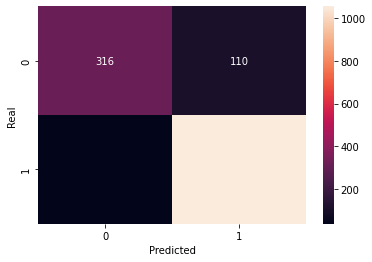

In [41]:
sns.heatmap(confusion_matrix, annot=True, fmt='g')
plt.show()

In [45]:
def calcular_metricas(y_real, y_pred):
    cm = confusion_matrix(y_real, y_pred)
    tn, fp, fn, tp = cm.ravel()
    accuracy = accuracy_score(y_real, y_pred)
    precision = precision_score(y_real, y_pred)
    recall = recall_score(y_real, y_pred)
    specificity = tn / (tn + fp)
    fpr = fp / (fp + tn)
    fnr = fn / (fn + tp)
    npv = tn / (tn + fn)
    f1 = f1_score(y_real, y_pred)
    metricas = {
        'Matriz de Confusión': cm,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall (Sensibilidad)': recall,
        'Specificity (Especificidad)': specificity,
        'F1-Score': f1,
        'False Positive Rate (FPR)': fpr,
        'False Negative Rate (FNR)': fnr,
        'Negative Predictive Value (NPV)': npv
    }
    for key, value in metricas.items():
        if key == 'Matriz de Confusión':
            print(f"{key}:\n{value}\n")
        else:
            print(f"{key}: {value:.4f}")

    return metricas

In [51]:
 calcular_metricas(y_test, y_predict)

Matriz de Confusión:
[[ 316  110]
 [  39 1054]]

Accuracy: 0.9019
Precision: 0.9055
Recall (Sensibilidad): 0.9643
Specificity (Especificidad): 0.7418
F1-Score: 0.9340
False Positive Rate (FPR): 0.2582
False Negative Rate (FNR): 0.0357
Negative Predictive Value (NPV): 0.8901


{'Matriz de Confusión': array([[ 316,  110],
        [  39, 1054]], dtype=int64),
 'Accuracy': 0.901909150757077,
 'Precision': 0.9054982817869416,
 'Recall (Sensibilidad)': 0.9643183897529735,
 'Specificity (Especificidad)': 0.7417840375586855,
 'F1-Score': 0.9339831634913603,
 'False Positive Rate (FPR)': 0.25821596244131456,
 'False Negative Rate (FNR)': 0.035681610247026534,
 'Negative Predictive Value (NPV)': 0.8901408450704226}

**_Validación Cruzada_**

In [49]:
modelo = Perceptron(random_state=42)

#hiperparámetros
param_grid = {
    'penalty': [None, 'l2', 'l1', 'elasticnet'],
    'alpha': [0.0001, 0.001, 0.01, 0.1],
    'max_iter': [1000, 2000]
}

#validación cruzada
grid_search = GridSearchCV(
    estimator=modelo,
    param_grid=param_grid,
    scoring='f1',
    cv=2,
    n_jobs=-1,
    verbose=2
)

# Entrenamiento
grid_search.fit(X, y)

print("Mejores hiperparámetros encontrados:")
print(grid_search.best_params_)

# Métrica
print(f"Mejor F1-Score: {grid_search.best_score_:.4f}")

# Utilizar el mejor modelo para predicciones
mejor_modelo = grid_search.best_estimator_


Fitting 2 folds for each of 32 candidates, totalling 64 fits


MemoryError: Unable to allocate 1.28 GiB for an array with shape (2532, 67600) and data type float64

**Reto**
- Te sentirías comodo con las metricas obtenidas para el modelo? 
- Una opción para mejorar las métricas sería urilizar las imágenes a color, queretos iml¿plica? 
- Otra manera es realizando una regularización al algoritmo.
- Pueden intentar algunas de las opciones anteriores? 

## Entrenamiento de perceptron utilizando penalizacion

In [56]:
model2 = Perceptron(max_iter=1000,  random_state=0, verbose=False,
                    penalty='l2', alpha=0.000001)
model2.fit(X_train,y_train)

print("Exactitud conjunto entrenamiento: %.2f%%" % (model2.score(  X_train, y_train)*100.0))
print("Exactitud conjunto prueba: %.2f%%" % (model2.score(X_test, y_test)*100.0))

Exactitud conjunto entrenamiento: 98.59%
Exactitud conjunto prueba: 92.03%


In [59]:
model_file = os.path.join(os.path.pardir,'modelos','perceptronV2.pkl')

model_file_pkl = open(model_file, 'wb')
pickle.dump(model2, model_file_pkl)
model_file_pkl.close()

In [58]:
model3 = Perceptron(max_iter=1000,
                    random_state=0,
                    verbose=False,
                    penalty='l1',
                    alpha=0.000005)

model3.fit(X_train,y_train)

print("Exactitud conjunto entrenamiento: %.2f%%" % (model3.score(X_train,
                                                                 y_train)*100.0))
print("Exactitud conjunto prueba: %.2f%%" % (model3.score(X_test,
                                                          y_test)*100.0))

Exactitud conjunto entrenamiento: 89.84%
Exactitud conjunto prueba: 86.18%


In [60]:
model_file = os.path.join(os.path.pardir,'modelos','perceptronV3.pkl')

model_file_pkl = open(model_file, 'wb')
pickle.dump(model3, model_file_pkl)
model_file_pkl.close()